## Objective:
- Fit a One vs All classifier for for different types of variable stars
- Use several different classifier methods: Random Forest, Decision Tree, Logistic Regression, Naive Bayes
- Create a comparision table for different classifiers and labels. Compare using metrics like accuracy, precision and recall

In [1]:
#Load libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Complete features and label table from Xiadian's website

In [2]:
widths = (8,7,4,13,43)
header_pd = pd.read_fwf('Labeled_data.txt', widths = widths,skiprows=7, nrows=27)
labeled_data = pd.read_csv('Labeled_data.txt', header=None, delim_whitespace=True, skiprows=36) # extract data
labeled_data.columns = header_pd.iloc[:,3]
labeled_data.head()
label = labeled_data.Type.unique()
label = np.delete(label, np.where(label == 'CEPII')) # CEPII has very few samples so we ignore it
print(label)

['BYDra' 'EW' 'SR' 'RSCVN' 'RR' 'DSCT' 'EA' 'Mira' 'RRc' 'CEP']


## Import features extracted from light curves
These features are caluclated on 1000 light curves of each variable type. The light curves are imported from variables.cn:88/
Feature list
- mean : mean of the light curve
- wmean : weight mean of the light curve
- MAD : deviation about the median
- IQR : inter quartile percentile of the light curve
- f60 : 60 percentile  of light curve
- f70 : 70 percentile of the light curve
- f80 : 80 percentile of the light curve
- f90 : 90 percentile of the light curve
- skew : skewness of the light curve
- kurtosis : kurtosis of the light curve
- welsk_k, welsh_j : welsh and staton J and K statistics of the light curve
- g_ : g band filter
- r_ : r band filter

In [3]:
df = pd.read_csv('features10000.csv', header=None, skiprows=1)
header = pd.read_csv('features10000.csv', header=None, nrows=1)
df.columns = header.iloc[0]

In [4]:
df.head()

,sourceid,ID,RAdeg,DEdeg,g_mean,g_wmean,g_MAD,g_IQR,g_f60,g_f70,...,r_IQR,r_f60,r_f70,r_f80,r_f90,r_skew,r_kurtosis,r_welsh_J,r_welsh_K,Type
0,1.0,ZTFJ000000.13+620605.8,0.000566,62.101631,17.994656,17.992102,0.034,0.07000,0.0820,0.10000,...,0.05125,0.0580,0.06655,0.0797,0.09370,0.105202,-0.632720,40.723268,1678.291273,BYDra
1,2.0,ZTFJ000000.14+721413.7,0.000620,72.237174,19.619402,19.579923,0.111,0.22650,0.2850,0.35950,...,0.22750,0.2712,0.30765,0.3614,0.44115,0.334634,-0.775188,258.579275,3360.702573,EW
2,3.0,ZTFJ000000.19+320847.2,0.000795,32.146449,15.313984,15.313984,0.072,0.14200,0.1580,0.18300,...,0.12600,0.1470,0.16080,0.1760,0.18860,-0.212606,-1.485137,171.745322,891.052032,EW
3,4.0,ZTFJ000000.26+311206.3,0.001085,31.201756,16.353295,16.353295,0.077,0.14900,0.1710,0.18700,...,0.10200,0.1322,0.15980,0.1946,0.20560,0.418285,-1.009552,202.025570,966.503331,EW
4,6.0,ZTFJ000000.30+233400.5,0.001249,23.566828,17.892283,17.878715,0.102,0.18975,0.2526,0.28225,...,0.22900,0.2700,0.29620,0.3132,0.33620,0.158998,-1.484462,253.787215,1019.579800,EW


In [5]:
# Drop rows with Blank values
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)

In [6]:
# get all unique labels
label = df.Type.unique()
print(label)

['BYDra' 'EW' 'SR' 'RSCVN' 'RR' 'DSCT' 'EA' 'RRc' 'Mira' 'CEP']


<AxesSubplot:xlabel='Type', ylabel='Count'>

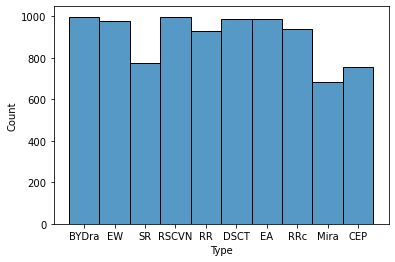

In [7]:
# Plot histogram of variable types in the dataset
import seaborn as sns
sns.histplot(data=df, x=df.Type)

## Various functions to create multiple classifiers

In [8]:
def multiple_to_2labels(df,variable_type):
    """
    converts multiple labels for diffrent variable types to only two labels for one vs all classifier.
    Returns 2 data frames: 
    1. Original data frame with new labels. 
    2. Dataframe with equal candidates of the two classes.
    """
    OneClass = variable_type
    df0 = df.copy()
    df0.loc[df0.Type != OneClass,'Type'] = 'Other'
    df1 = df0[df0.Type == 'Other']
    df2 = df0[df0.Type == OneClass]

    df3 = df1.sample(n=1000, random_state=1) # balance data type by only selecting 1000 of other type
    frames = [df2,df3]
    df_onevsall = pd.concat(frames)
    return df0, df_onevsall

In [9]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
def preprocess_data(df):
    """
    Preprocess data for one vs all classifier and split it to train/test data
    """
    # Map string labels to numbers
    label = df.Type

    le = preprocessing.LabelEncoder()
    le.fit(label)

    # Drop columns that are not features
    X = df
    # Encode labels to form y labels
    y = le.transform(df.Type)

    # Split dataset into training set and test set
    X_tr, X_ts, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
    X_train = X_tr.drop(['Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')
    X_test = X_ts.drop(['Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')
    return X_train, X_test, y_train, y_test
    

In [10]:

from sklearn import metrics
# from sklearn.metrics import confusion_matrix
def oneVSall_classiffier(model,X_train, X_test, y_train, y_test):
    """
    Train Classifier using train dataset. Calculate classifier metrics using test dataset
    """
    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train,y_train)

    # Predict test data output
    y_pred = clf.predict(X_test)
    
    # Estimate model accuracy on test data
    accuracy = metrics.accuracy_score(y_test, y_pred)
    confusion = metrics.confusion_matrix(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
                                      
    return clf, accuracy, precision, recall, confusion

## Train and Compare Classifiers

In [11]:
# list of classification methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

names = ["Random Forest", "Decision Tree", "Logistic Regression", "Naive Bayes"]

classifiers = [
    RandomForestClassifier(n_estimators=100),
    DecisionTreeClassifier(criterion="gini", max_depth=3),
    LogisticRegression(max_iter = 500),
    GaussianNB()]


In [12]:
# Run loop to train all classifiers and collect metrics in a dataframe
accuracy ={}
precision = {}
recall = {}
confusion ={}

# create comparision dataframe
header = pd.MultiIndex.from_product([names,
                                     ['accuracy','precision','recall']],
                                    names=['clf','metric'])
index_label = label
pd_comparison = pd.DataFrame(data=None, index=index_label, columns=header, dtype=None, copy=False)

# train models and collect metrics on test data
for name, clf in zip(names, classifiers): # loop over different classifiers
    print(name)
    accuracy[name] = {}
    precision[name] = {}
    recall[name] = {}
    confusion[name] ={}
    for variable_type in label: #loop over different types of variable stars
        print(variable_type)
        df0, df_onevsall = multiple_to_2labels(df,variable_type)
        X_train, X_test, y_train, y_test = preprocess_data(df0)
        clf, accuracy[name][variable_type],precision[name][variable_type],recall[name][variable_type], confusion[name][variable_type] = oneVSall_classiffier(clf,X_train, X_test, y_train, y_test)
    pd_comparison.loc[:,(name,'accuracy')] = list(accuracy[name].values())
    pd_comparison.loc[:,(name,'precision')] = list(precision[name].values())
    pd_comparison.loc[:,(name,'recall')] = list(recall[name].values())

Random Forest
BYDra
EW
SR
RSCVN
RR
DSCT
EA
RRc
Mira
CEP
Decision Tree
BYDra
EW
SR
RSCVN
RR
DSCT
EA
RRc
Mira
CEP
Logistic Regression
BYDra


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


EW


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SR


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RSCVN
RR


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DSCT


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


EA


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RRc


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mira


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CEP


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Naive Bayes
BYDra
EW
SR
RSCVN
RR
DSCT
EA
RRc
Mira
CEP


In [13]:
# print the comparision table
pd_comparison.head(20)

clf    Random Forest                     Decision Tree                      \
metric      accuracy precision    recall      accuracy precision    recall   
BYDra       0.909527  0.927767  0.975899      0.892171  0.892171  1.000000   
EW          0.938700  0.943545  0.990468      0.897710  0.898042  0.999589   
SR          0.949778  0.956522  0.456432      0.902142  0.462857  0.321429   
RSCVN       0.904727  0.733333  0.220000      0.891064  0.609756  0.082237   
RR          0.960118  0.863436  0.717949      0.932792  0.733591  0.627063   
DSCT        0.922083  0.930577  0.986358      0.889586  0.894619  0.992949   
EA          0.977843  0.987094  0.987917      0.969719  0.984480  0.981187   
RRc         0.956425  0.893204  0.657143      0.937223  0.849315  0.455882   
Mira        0.997046  0.998399  0.998399      0.996677  0.998801  0.997606   
CEP         0.955687  0.959734  0.993123      0.919498  0.928436  0.988311   

clf    Logistic Regression                     Naive Bayes                      
metric            accuracy precision    recall    accuracy precision    recall  
BYDra             0.887371  0.889466  0.997089    0.515879  0.992933  0.463123  
EW                0.895864  0.905753  0.986397    0.302806  0.984645  0.214375  
SR                0.937592  0.785714  0.441767    0.283235  0.089829  0.879070  
RSCVN             0.892171  0.500000  0.051370    0.500369  0.181597  0.967532  
RR                0.950517  0.790795  0.692308    0.706795  0.239109  0.968627  
DSCT              0.890694  0.902411  0.982910    0.429468  0.983462  0.368291  
EA                0.972304  0.981833  0.987132    0.436484  0.997709  0.363674  
RRc               0.948671  0.791489  0.673913    0.665436  0.237043  0.972125  
Mira              0.997046  0.998395  0.998395    0.983752  1.000000  0.982505  
CEP               0.947194  0.956065  0.987947    0.501846  0.983747  0.463710